In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from fastdtw import fastdtw
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.spatial.distance import euclidean
from sktime.classification.interval_based import RandomIntervalSpectralEnsemble
from tsai.all import TSClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.pipeline import make_pipeline, Pipeline
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sklearn.tree import DecisionTreeClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.utils.slope_and_trend import _slope

# Data Split

In [96]:
data = pd.read_csv('classification_data.csv',index_col=0)
train = pd.concat([data[data['label']==1].head(10), data[data['label']==2].head(10), data[data['label']==3].head(10)],axis=0,ignore_index=True)
x_train, y_train = train.iloc[:,1:704], train.iloc[:,-1]
test = pd.concat([data[data['label']==1].tail(10), data[data['label']==2].tail(10), data[data['label']==3].tail(10)],axis=0,ignore_index=True)
x_test, y_test = test.iloc[:,1:704], test.iloc[:,-1]

In [29]:
# examine distribution of classes
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

[1 2 3] [10 10 10]


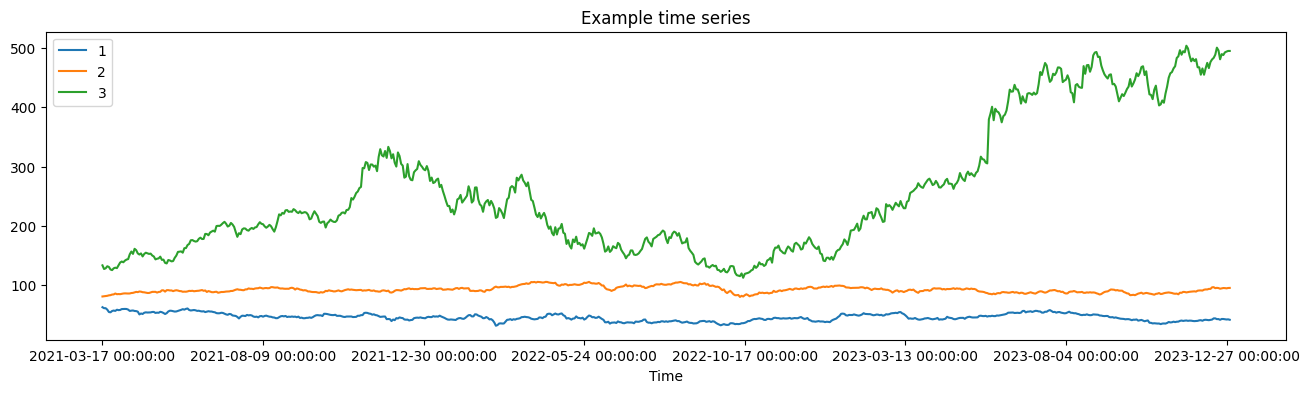

In [30]:
# Plot 1 example of each class
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    x_train.loc[y_train == label].iloc[0].plot(ax=ax, label=label) #select one ts from each sport category
plt.legend()
ax.set(title="Example time series", xlabel="Time");

# KNN with DTW

In [60]:
# Function to compute the DTW distance between two time series
def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2, dist=2)
    return distance

# Function to compute the DTW distance matrix
def compute_dtw_distance_matrix(X_train, X_test):
    num_train = len(X_train)
    num_test = len(X_test)
    distance_matrix = np.zeros((num_test, num_train))
    
    for i in range(num_test):
        for j in range(num_train):
            distance_matrix[i, j] = dtw_distance(X_train.iloc[j], X_test.iloc[i])
    
    return distance_matrix

distance_matrix_train = compute_dtw_distance_matrix(x_train, x_train)
distance_matrix_test = compute_dtw_distance_matrix(x_train, x_test)

# Initialize and train the KNN with DTW using precomputed distance matrix

knn1 = KNeighborsClassifier(n_neighbors=3, metric='precomputed')
knn1.fit(distance_matrix_train, y_train)

# Predict using the precomputed distance matrix for test data
y_pred1 = knn1.predict(distance_matrix_test)

# Evaluate the model
accuracy1 = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy1}')
print(classification_report(y_test, y_pred1))

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.78      0.70      0.74        10
           3       0.70      0.70      0.70        10

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.76        30
weighted avg       0.77      0.77      0.76        30



In [71]:
knn2 = KNeighborsClassifier(n_neighbors=1, metric='precomputed')
knn2.fit(distance_matrix_train, y_train)

y_pred2 = knn2.predict(distance_matrix_test)

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2}')
print(classification_report(y_test, y_pred2))

Accuracy: 0.8
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10
           3       0.70      0.70      0.70        10

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.80      0.80      0.80        30



# Random Forest Classifier

In [85]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train)
# Get the best estimator
best_rf_clf = grid_search.best_estimator_
# Train the model with the best parameters
best_rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=4,
                       min_samples_split=10, random_state=42)

In [86]:
y_pred = best_rf_clf.predict(x_test)
# Calculate accuracy scores
train_accuracy = best_rf_clf.score(x_train, y_train)
test_accuracy = best_rf_clf.score(x_test, y_test)
# Print accuracy scores
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.8666666666666667
Test Accuracy: 0.6666666666666666


In [87]:
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[9 0 1]
 [4 4 2]
 [3 0 7]]

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.90      0.69        10
           2       1.00      0.40      0.57        10
           3       0.70      0.70      0.70        10

    accuracy                           0.67        30
   macro avg       0.75      0.67      0.65        30
weighted avg       0.75      0.67      0.65        30



# Random Forest with Feature Extraction

In [141]:
# # Convert the data to sktime compatible format (nested pandas DataFrame)
X_train_nested = from_2d_array_to_nested(x_train)
X_test_nested = from_2d_array_to_nested(x_test)

#feature extraction
transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train_nested)

#random forest with feature extraction
rffeclassifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier(random_state=0)
)
rffeclassifier.fit(X_train_nested, y_train)
y_pred_rffe = rffeclassifier.predict(X_test_nested)

#evaluation metrics
test_accuracy_rffe = rffeclassifier.score(X_test_nested, y_test)
print(f"Test Accuracy: {test_accuracy_rffe}")
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rffe))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rffe))

Feature Extraction: 100%|██████████| 30/30 [00:02<00:00, 14.60it/s]


Test Accuracy: 0.9333333333333333
Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 1  1  8]]

Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        10
           2       0.91      1.00      0.95        10
           3       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



# Time Series Forest Classification model

In [140]:
steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)
time_series_tree.fit(X_train_nested, y_train)
time_series_tree.score(X_test_nested, y_test)

0.6666666666666666

In [143]:
tsf = TimeSeriesForestClassifier(
    #estimator=time_series_tree,
    n_estimators=100,
    #criterion="entropy",
   # bootstrap=True,
   # oob_score=True,
    random_state=0,
    n_jobs=-1,
)

tsf_fit = tsf.fit(X_train_nested, y_train)
y_pred_tsf = tsf_fit.predict(X_test_nested)

#evaluation metrics
test_accuracy_tsf = tsf_fit.score(X_test_nested, y_test)
print(f"Test Accuracy: {test_accuracy_tsf}")
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tsf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tsf))

Test Accuracy: 0.8333333333333334
Confusion Matrix:
[[7 2 1]
 [0 9 1]
 [1 0 9]]

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.70      0.78        10
           2       0.82      0.90      0.86        10
           3       0.82      0.90      0.86        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



### Feature importance

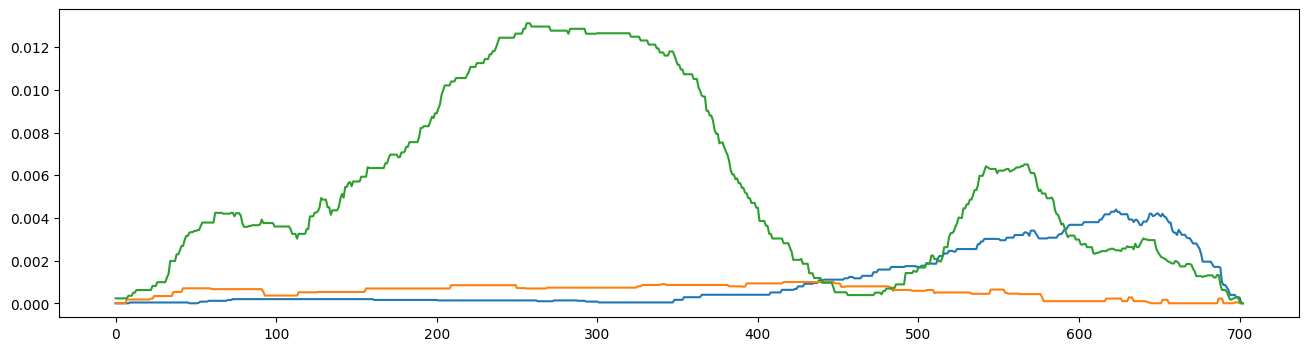

In [144]:
fi = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
#fi.plot(ax=ax)
plt.plot(fi)
ax.set_xlabel ="Time"
ax.set_ylabel="Feature importance"
plt.show()

# RISE

In [130]:
rise = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=42)
rise.fit(X_train_nested, y_train)
y_pred_rise = rise.predict(X_test_nested)
print( confusion_matrix(y_test, y_pred_rise) )
print( classification_report(y_test, y_pred_rise) )

[[6 3 1]
 [0 9 1]
 [0 1 9]]
              precision    recall  f1-score   support

           1       1.00      0.60      0.75        10
           2       0.69      0.90      0.78        10
           3       0.82      0.90      0.86        10

    accuracy                           0.80        30
   macro avg       0.84      0.80      0.80        30
weighted avg       0.84      0.80      0.80        30

